In [1]:
import pandas as pd
import numpy as np
import lasio
import matplotlib.pyplot as plt
from IPython.display import clear_output
import re
import random
from scipy.spatial import KDTree
import seaborn as sns
import copy

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 9)
plt.style.use('dark_background')

In [3]:
las = lasio.read('file1.las')
df = las.df()

In [4]:
df = df.replace(-9999.0, np.nan)
df = df.dropna(how='all')
df /= df.max()
df.head()

,DTC,GR,NEUT
DEPT,,,
1522.1710,NaN,0.154196,NaN
1522.3234,NaN,0.154196,NaN
1522.4758,NaN,0.154196,NaN
1522.6282,NaN,0.154196,NaN
1522.7806,NaN,0.154196,NaN


In [5]:
pd.concat([df.head(),df.tail()])

,DTC,GR,NEUT
DEPT,,,
1522.1710,NaN,0.154196,NaN
1522.3234,NaN,0.154196,NaN
1522.4758,NaN,0.154196,NaN
1522.6282,NaN,0.154196,NaN
1522.7806,NaN,0.154196,NaN
2312.5174,NaN,0.286575,0.106987
2312.6698,NaN,0.286575,0.106987
2312.8222,NaN,0.286575,0.106987
2312.9746,NaN,0.286575,0.106987


               DTC           GR         NEUT
count  4952.000000  5191.000000  4867.000000
mean      0.783155     0.584940     0.221396
std       0.128243     0.207766     0.071334
min       0.384416     0.133622     0.035011
25%       0.728414     0.507911     0.187941
50%       0.829502     0.650832     0.222359
75%       0.868317     0.719400     0.250809
max       1.000000     1.000000     1.000000


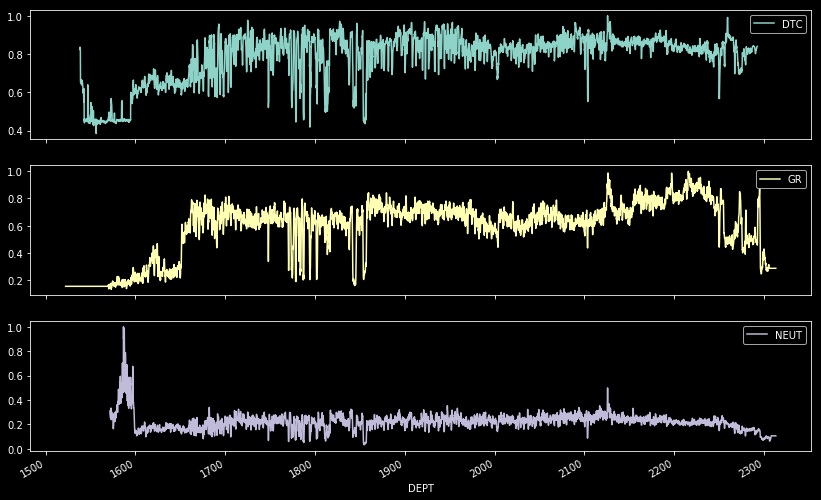

In [6]:
print(df.describe())
df.plot(subplots=True);

In [7]:
df2 = pd.read_csv('../datasets/CampusBasin/dataset.csv', index_col=0)
df2 = df2[df2.index.to_series().str.contains('ENC-3-RJS')]

petrofacies = pd.concat([df2.index.to_series(),df2['petrofacie']], axis=1)
petrofacies.columns = ['DEPT', 'petrofacie']

def id_to_DEPT(name):
    DEPT = re.search('[0-9]+[,|.][0-9]+', name)
    return float(DEPT.group(0).replace(',', '.'))
    
petrofacies.index = petrofacies['DEPT'].apply(id_to_DEPT)
del petrofacies['DEPT']
petrofacies

,petrofacie
DEPT,
2304.46,SandMarl
2304.20,SandMarl
2291.75,FinIntra
2290.42,FinIntra
2285.62,CoarGlauCal
2284.70,CoarPor
2276.50,CoarPor
2274.60,CoarPor
2273.72,CoarPor


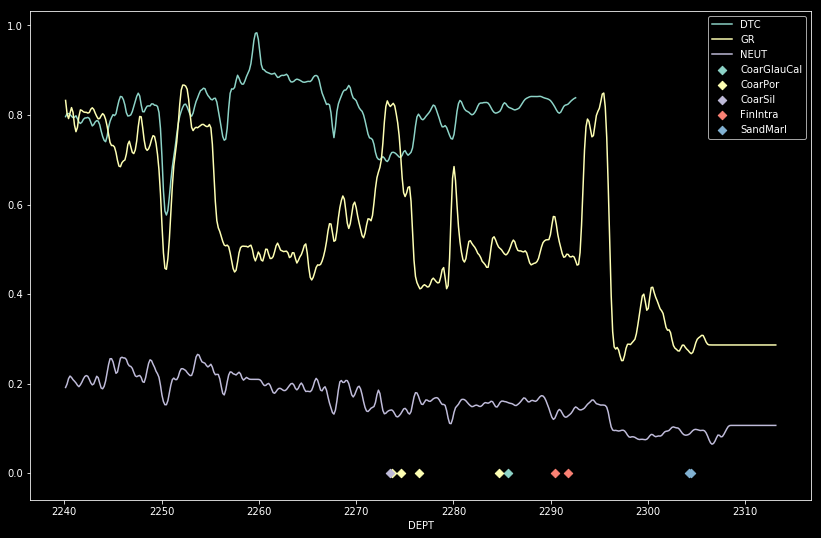

In [8]:
df.rolling(5, win_type='hamming').mean()[2240:].plot()

for name, group in petrofacies.groupby('petrofacie'):
    plt.scatter(group.index,[0 for _ in range(group.shape[0])], label=name, marker='D')
plt.legend();

In [9]:
delta = 5 # meters
group_stats = {}
for name, group in petrofacies.groupby('petrofacie'):
    for row in group.iterrows():
        dept = row[0]
        mean = df[dept-delta:dept+delta].apply(lambda col: np.average(col.values, weights=np.hamming(len(col))), axis=0)
        if name in group_stats:
            group_stats[name] = pd.concat([group_stats[name], mean], axis=1).mean(axis=1)
        else:
            group_stats[name] = mean
            
for key, value in group_stats.items():
    print(f'{key}:')
    print(f'{value}\n')

CoarGlauCal:
DTC     0.822367
GR      0.496844
NEUT    0.157661
dtype: float64

CoarPor:
DTC     0.751589
GR      0.602547
NEUT    0.150727
dtype: float64

CoarSil:
DTC     0.735100
GR      0.650493
NEUT    0.149433
dtype: float64

FinIntra:
DTC          NaN
GR      0.550577
NEUT    0.144694
dtype: float64

SandMarl:
DTC          NaN
GR      0.295079
NEUT    0.090594
dtype: float64



In [10]:
centers = []
for value in group_stats.values():
    centers.append(value.values)
    
tree = KDTree(centers)

In [11]:
assigned_petrofacies = []

sub_df = df.rolling(delta, win_type='hamming').mean()

petrofacies_keys = list(group_stats.keys())+['None']
for row in df.iterrows():
    assigned_petrofacies.append(petrofacies_keys[tree.query(row[1:])[1][0]])
    
assigned_petrofacies = pd.Series(assigned_petrofacies)
assigned_petrofacies.index = df.index

In [12]:
assigned_df = copy.deepcopy(df)
assigned_df['assigned_petrofacie'] = assigned_petrofacies

/home/pugens/.conda/envs/mestrado/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


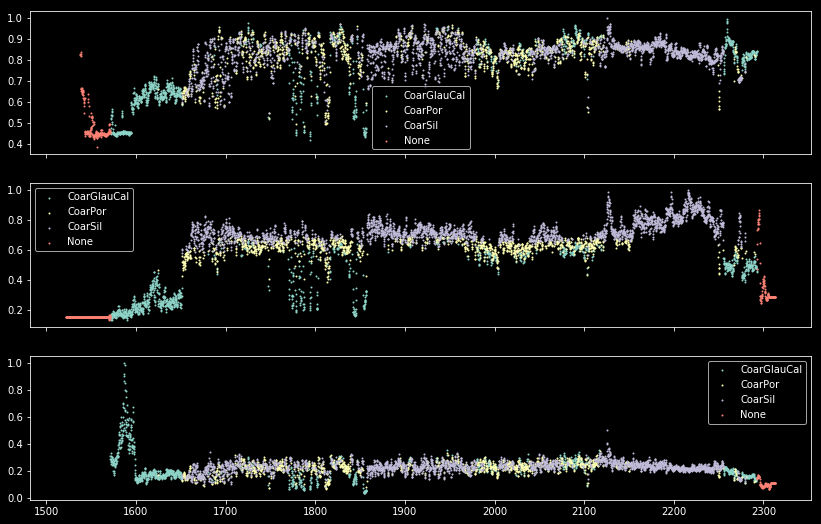

In [14]:
grouped = assigned_df.groupby('assigned_petrofacie')

fig, axs = plt.subplots(df.shape[1], 1, sharex=True)

for petrofacie, group in grouped:
    for i, measurement in enumerate(group):
        if measurement == 'assigned_petrofacie':
            continue
        axs[i].scatter(group.index.values, group[measurement].values, label=petrofacie, s=1)
        axs[i].legend()
    
fig.show()